#Healthcare AI


In [1]:
!unzip '/content/drive/My Drive/Healthcare AI/Healthcare+AI+Datasets.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16_mask.tif  
  inflating: Healthcare AI Datase

In [2]:
import os
import PIL
import zipfile

import pandas as pd
import numpy as np
import cv2    
from skimage import io
import pickle
from PIL import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')

In [3]:
# brain_df = pd.read_csv('/content/Healthcare AI Datasets/Brain_MRI/data.csv')
brain_df = pd.read_csv('/content/Healthcare AI Datasets/Brain_MRI/data_mask.csv')

In [4]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
brain_df.shape

(3929, 4)

In [7]:
brain_df.columns

Index(['patient_id', 'image_path', 'mask_path', 'mask'], dtype='object')

In [8]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# Data visualization

In [9]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, y=brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)', marker_line_color='rgb(255,0,0)',
                  marker_line_width=3,opacity=0.6)
fig.show()

In [10]:
%cd '/content/Healthcare AI Datasets/Brain_MRI'

/content/Healthcare AI Datasets/Brain_MRI


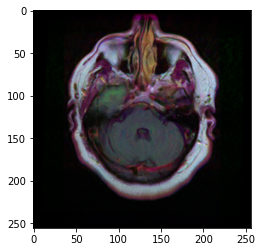

In [11]:
plt.imshow(cv2.imread(brain_df.image_path[623]));

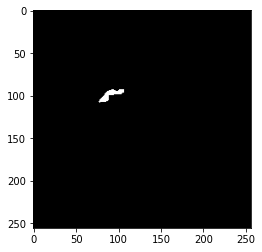

In [12]:
plt.imshow(cv2.imread(brain_df.mask_path[623]));

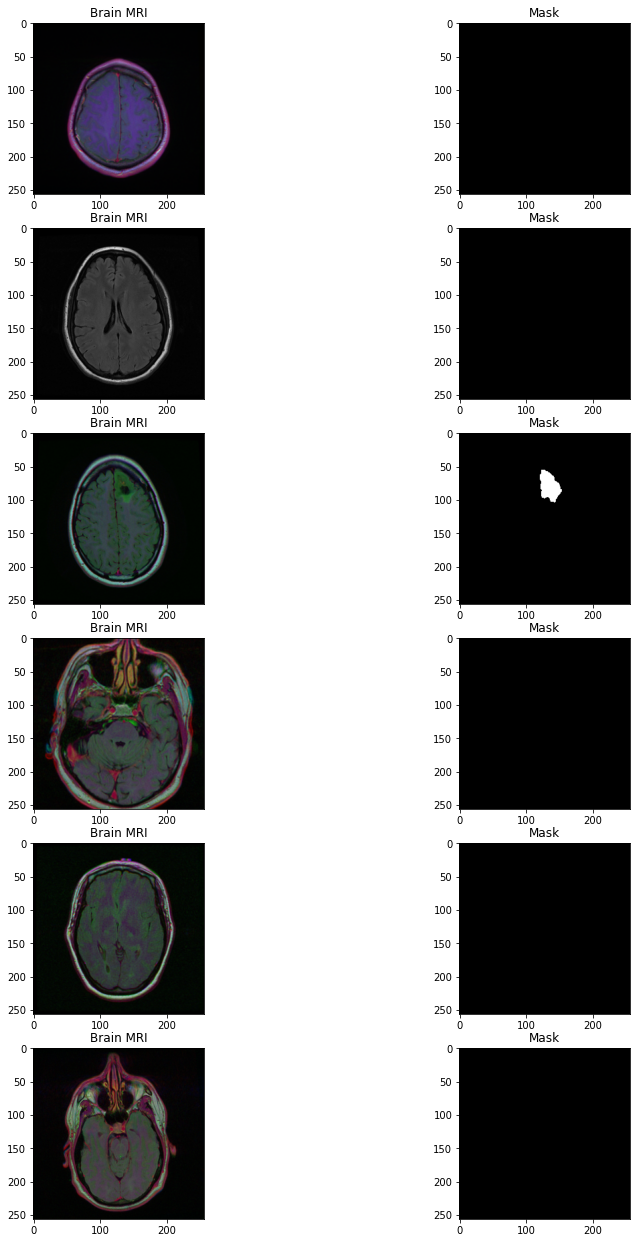

In [13]:
import random
fig, ax = plt.subplots(6,2, figsize=(14,22))
for x in range(6):
    i = random.randint(0, len(brain_df))
    ax[x][0].title.set_text('Brain MRI')
    ax[x][0].imshow(cv2.imread(brain_df.image_path[i]))
    
    ax[x][1].title.set_text('Mask')
    ax[x][1].imshow(cv2.imread(brain_df.mask_path[i]))

fig.show();

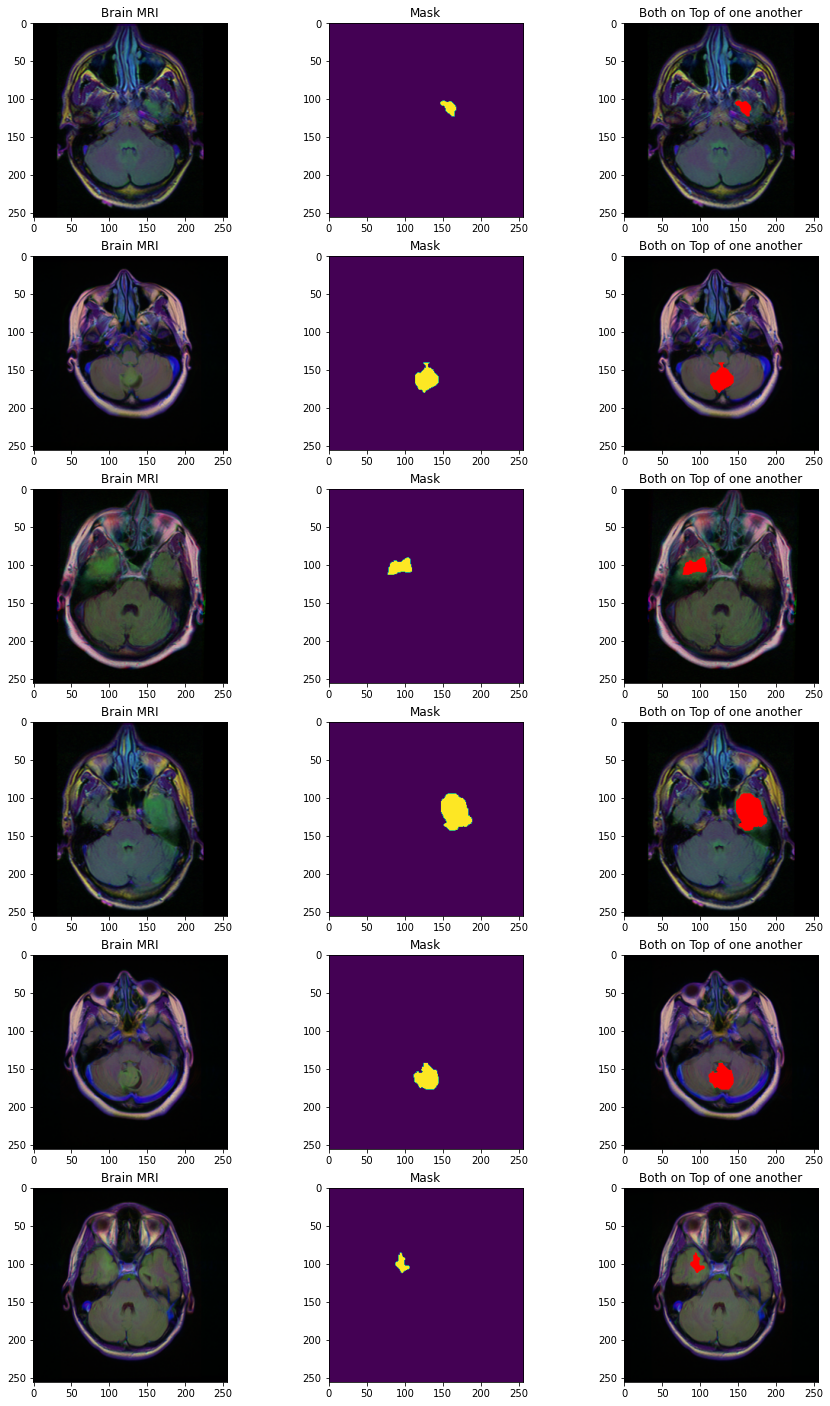

In [14]:
fig, ax = plt.subplots(6,3, figsize=(15,25))
counter=0
for i in range(len(brain_df)):
    if brain_df['mask'][i]==1 and counter<6:
        img = io.imread(brain_df.image_path[i])
        ax[counter][0].title.set_text('Brain MRI')
        ax[counter][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        ax[counter][1].title.set_text('Mask')
        ax[counter][1].imshow(mask)

        img[mask==255] = (255,0,0)
        ax[counter][2].title.set_text('Both on Top of one another')
        ax[counter][2].imshow(img)
        counter+=1
fig.show();

# Praparing dataset

In [15]:
# Dropping patient_id column
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [16]:
# Converting the mask column to the type str. This is required by flow_from_dataframe method.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [17]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [18]:
# Splitting dataset into training and testing set
train, test = train_test_split(brain_df_train, test_size=0.15)

In [19]:
# Creating Data generators for Train, test and validation splits
BATCH_SIZE = 16
#Data generator object
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)

# Train data generator
train_generator = datagen.flow_from_dataframe(train,
                                            directory='./',
                                            x_col='image_path',
                                            y_col='mask',
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            subset='training',
                                            class_mode='categorical',
                                            target_size=(256,256)
                                            )

# Validation Data generator
valid_generator = datagen.flow_from_dataframe(train,
                                           directory='./',
                                           x_col='image_path',
                                           y_col = 'mask',
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           subset='validation',
                                           class_mode='categorical',
                                           target_size=(256,256)
                                           )

# test Data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Building Our Model

In [20]:
# Getting a pretrained ResNet50 model and downloading it
basemodel = ResNet50(include_top=False, weights='imagenet', input_tensor= Input(shape=(256, 256, 3)))
# Printing the model summary    
basemodel.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [21]:
# Freezing the model layers
for layer in basemodel.layers:
    layer.trainable=False

In [22]:
# Building our own model on the top of the basemodel
model = basemodel.output
model = AveragePooling2D(pool_size=(4,4))(model)
model = Flatten(name='Flatten')(model)
model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(2, activation='softmax')(model)
model = Model(inputs=basemodel.input, outputs=model)

#printing our model's summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [26]:
# Compile the model
# sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [27]:
# Defining callbacks
checkpt = ModelCheckpoint('./weights1.hdf5',monitor='val_loss', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=8)
lrreduce = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, min_lr=0.0000001)

In [28]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//BATCH_SIZE,
                    epochs=100,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.n//BATCH_SIZE,
                    callbacks = [checkpt, earlystop, lrreduce]  
                    )

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.8569
Epoch 00001: val_loss improved from inf to 0.29951, saving model to ./weights1.hdf5
177/177 [==============================] - 16s 89ms/step - loss: 0.2368 - accuracy: 0.8569 - val_loss: 0.2995 - val_accuracy: 0.8952
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.8597
Epoch 00002: val_loss did not improve from 0.29951
177/177 [==============================] - 15s 82ms/step - loss: 0.2228 - accuracy: 0.8597 - val_loss: 0.3135 - val_accuracy: 0.8891
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.8622
Epoch 00003: val_loss did not improve from 0.29951
177/177 [==============================] - 15s 82ms/step - loss: 0.2203 - accuracy: 0.8622 - val_loss: 0.3150 - val_accuracy: 0.8911
Epoch 4/100
177/177 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.8636
Epoch 00004: val_loss did n

In [29]:
#Save the model
model_jsn = model.to_json()
with open('./brain_tumor_model.json', 'w') as json_file:
    json_file.write (model_jsn) 

# Assessing the trained Model

In [106]:
# Load the architecture
with open('resnet-50-MRI.json') as json_file:
    json_savedModel = json_file.read()

# Load the model weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
#Make Prediction
test_predict = model.predict(test_generator,steps=test_generator.n//BATCH_SIZE, verbose=1)

36/36 [==============================] - 2s 67ms/step


In [108]:
test_predict.shape # We have 2 outputs, because we have 2 classes

(576, 2)

In [109]:
test_predict

array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [2.2596047e-29, 1.0000000e+00]], dtype=float32)

In [110]:
# Obtain actual predicted labels
preds = []
for i in test_predict:
    preds.append(str(np.argmax(i)))
preds = np.asarray(preds)

In [111]:
preds[:10]

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U1')

In [112]:
# Getting true labels
original = np.asarray(test['mask'])[:len(preds)]
print(len(original))

576


Accuracy:  0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       384
           1       0.33      0.99      0.50       192

    accuracy                           0.33       576
   macro avg       0.42      0.50      0.25       576
weighted avg       0.44      0.33      0.17       576



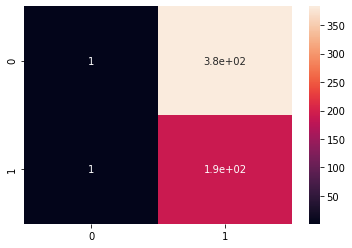

In [113]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(original, preds)
cm = confusion_matrix(original, preds)
print('Accuracy: ',accuracy)
print(classification_report(original, preds))
sns.heatmap(cm, annot=True);

# Part 2: Building another model to localize tumor

In [38]:
# Get the datasets which have mask
brain_df_mask = brain_df[brain_df['mask']==1]
brain_df_mask.shape

(1373, 4)

In [39]:
# Split the data into train and test dataset
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [40]:
# create separate list for imageip and labels
train_ids = list(X_train.image_path)
train_mask = list(X_train['mask_path'])

val_ids = list(X_val.image_path)
val_mask = list(X_val['mask_path'])

In [41]:
from utilities import DataGenerator

training_gen = DataGenerator(train_ids, train_mask)
validation_gen = DataGenerator(val_ids, val_mask)

# Creating ResUNet 

In [42]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [43]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [44]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [45]:
model_seg.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

# Training ResUNet

In [92]:
from utilities1 import focal_tversky, tversky_loss, tversky

In [93]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [94]:
# Defining callbacks
checkpt = ModelCheckpoint('./healthcare_resunet_weights.hdf5',monitor='val_loss', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=11)

In [95]:
# history2 = model_seg.fit(training_gen, epochs=10,
#                       validation_data=validation_gen, 
#                       callbacks=[checkpt, earlystop]
#                       )

In [96]:
# save the model architecture to json file for future use
# model_json = model_seg.to_json()
# with open("healthcare_resunet_model.json","w") as json_file:
#   json_file.write(model_json)

In [114]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model2 = tf.keras.models.model_from_json(json_savedModel)
model2.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.01, epsilon = 0.1)
model2.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [115]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model2)

In [116]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_12...,No mask,0
1,TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18...,No mask,0
2,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27...,"[[[[7.347846e-07], [2.6421499e-06], [4.6542677...",1
3,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13...,"[[[[7.978864e-07], [2.8075394e-06], [5.0320245...",1
4,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10...,No mask,0
...,...,...,...
585,TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_3.tif,No mask,0
586,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_7.tif,No mask,0
587,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_51...,No mask,0
588,TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_15...,No mask,0


In [117]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_12...,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_12...,0,No mask,0
1,TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18...,TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18...,0,No mask,0
2,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27...,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27...,1,"[[[[7.347846e-07], [2.6421499e-06], [4.6542677...",1
3,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13...,TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13...,1,"[[[[7.978864e-07], [2.8075394e-06], [5.0320245...",1
4,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10...,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_10...,0,No mask,0


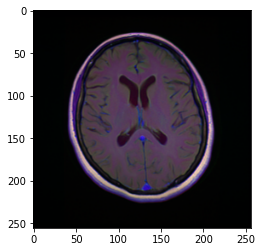

In [119]:
plt.imshow(cv2.cvtColor(cv2.imread(df_pred.image_path[0]), cv2.COLOR_BGR2RGB));

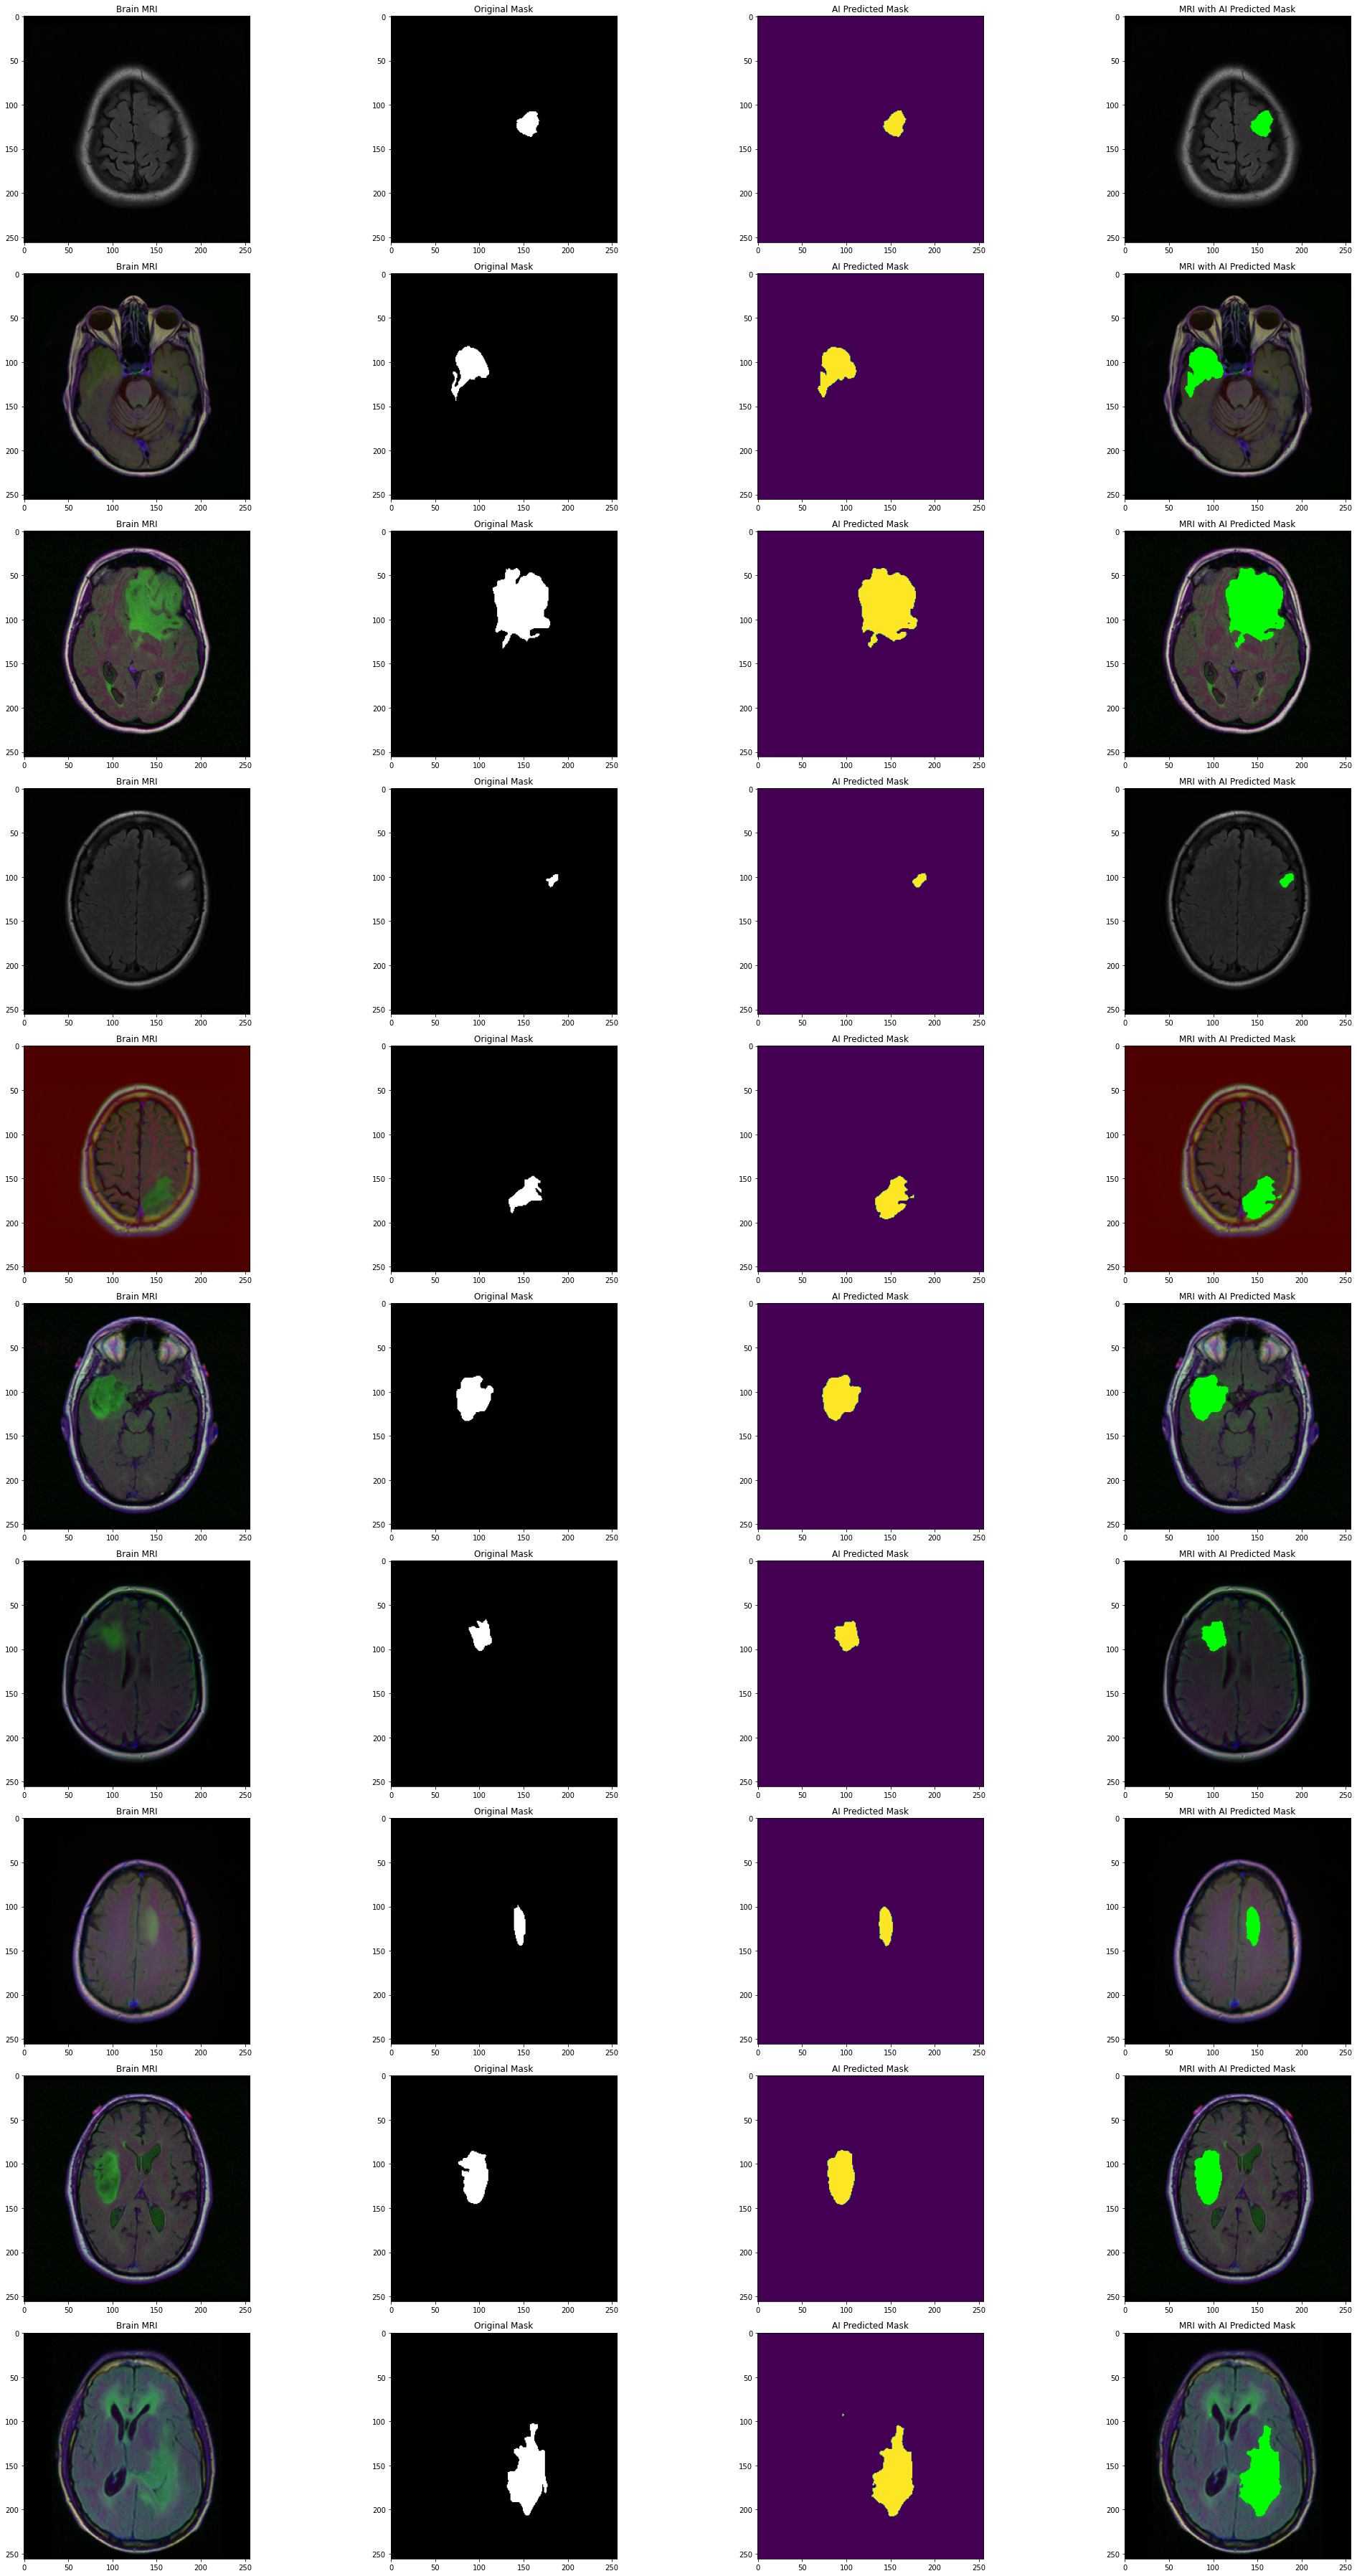

In [121]:
count = 0 
fig, axs = plt.subplots(10, 4, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    # img = cv2.imread(df_pred.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(df_pred.image_path[i]), cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img);
    # axs[count][0].imshow(img)

    # Obtain the mask for the image 
    masks = cv2.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(masks)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    # img[masks==255] = (255, 0, 0)
    # axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    # axs[count][3].imshow(img)

    img_ = cv2.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][3].title.set_text("MRI with AI Predicted Mask")
    axs[count][3].imshow(img_)
    count += 1

fig.tight_layout()